## Imports

In [1]:
from constants import FLUXES_FOLDER, SLM_FOLDER

from data_utils import process_amp_phase_data

from plot_utils import plot_map, \
                       plot_model_history, \
                       plot_fully_connected_amp_phase_prediction, \
                       plot_conv_amp_phase_prediction

from modeling_utils import create_fully_connected_architecture_for_amplitude_and_phase_reconstruction, \
                           create_convolutional_architecture_for_amplitude_and_phase_reconstruction, \
                           compile_model, \
                           train_model

from configurations import FCDropoutL1 as ModelConfig

2023-12-09 17:55:12.707622: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-09 17:55:12.781439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-09 17:55:12.781462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-09 17:55:12.782857: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-09 17:55:12.804774: I tensorflow/core/platform/cpu_feature_guar

## Load data

In the first place, define the data paths

In [2]:
train_fluxes_array, val_fluxes_array, train_amp_phase_array, val_amp_phase_array, scalers = \
    process_amp_phase_data(
        n_points=35000,
        trim_amplitude=False,
        trim_phase=False,
        normalize_flux=True,
        normalize_amplitude=True,
        shuffle=False,
        flatten_fluxes=True,
        split=True,
        val_ratio=0.1
    )

## FULLY CONNECTED

## Define configuration

In [3]:
model_configuration = ModelConfig(train_fluxes_array,
                                  train_amp_phase_array)
print(model_configuration.get_description())


	=== FCDropoutL1 ===
	*ARCHITECTURE HYPERPARAMETERS:
		-Fully Connected
		-Input shape: (1320,)
		-Output shape: (2, 96, 96)
		-Hidden layers: [1024, 2048, 2048, 2048]
		-Regularizer: L1 (0.05)
		-Hidden Layers Activation: relu
		-Output Layer Activation: linear
		-Batch Normalization: False
		-Dropout: True 0.1
	
	*COMPILATION HYPERPARAMETERS:
		-Optimizer: ADAM lr=0.01, beta_1=0.9, beta_2=0.999
		-Loss Function: MSE
		-Metric: MSE
	
	* TRAINING HYPERPARAMETERS:
		-Epochs: 500
		-Batch size: 128
		-Callbacks:
			-ReduceLROnPlateau: MSE 30 x0.1
			-Early Stop: MSE 100
	


2023-12-09 17:55:40.023343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 17:55:40.126088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-09 17:55:40.126888: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Instantiate model

In [4]:
model = create_fully_connected_architecture_for_amplitude_and_phase_reconstruction(
    *model_configuration.unpack_architecture_hyperparameters()
)


Model: "FCDropoutL1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              1351680   
                                                                 
 activation (Activation)     (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 2048)              2097152   
                                                                 
 activation_1 (Activation)   (None, 2048)              0         
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2048)              

## Compile model

In [5]:
compile_model(
    model,
    *model_configuration.unpack_compilation_hyperparameters()
)

## Train model

In [6]:
history = train_model(
    model,
    train_fluxes_array,
    train_amp_phase_array,
    val_fluxes_array,
    val_amp_phase_array,
    *model_configuration.unpack_training_hyperparameters()
)

Epoch 1/500


2023-12-09 17:55:43.866967: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-09 17:55:44.653450: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8b51d96be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-09 17:55:44.653466: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-12-09 17:55:44.665397: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-09 17:55:44.714755: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1702104944.813589   65195 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


247/247 [==============================] - 8s 23ms/step - loss: 880.2128 - mean_squared_error: 855.2556 - val_loss: 24.3168 - val_mean_squared_error: 0.9506 - lr: 0.0100
Epoch 2/500
247/247 [==============================] - 5s 22ms/step - loss: 22.9655 - mean_squared_error: 0.7989 - val_loss: 22.2237 - val_mean_squared_error: 1.0309 - lr: 0.0100
Epoch 3/500
247/247 [==============================] - 5s 22ms/step - loss: 21.4154 - mean_squared_error: 0.7928 - val_loss: 21.0311 - val_mean_squared_error: 1.0567 - lr: 0.0100
Epoch 4/500
247/247 [==============================] - 6s 23ms/step - loss: 20.1619 - mean_squared_error: 0.7127 - val_loss: 20.0824 - val_mean_squared_error: 1.0890 - lr: 0.0100
Epoch 5/500
247/247 [==============================] - 5s 22ms/step - loss: 19.2679 - mean_squared_error: 0.6962 - val_loss: 19.2873 - val_mean_squared_error: 1.0771 - lr: 0.0100
Epoch 6/500
247/247 [==============================] - 5s 22ms/step - loss: 18.6199 - mean_squared_error: 0.7162 -

## Results

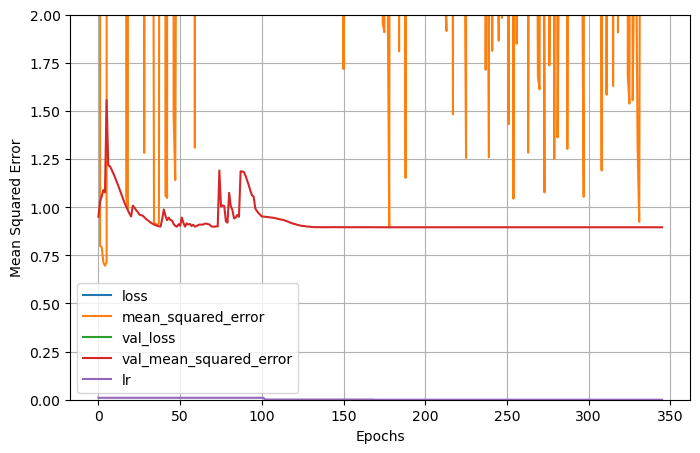

In [7]:
plot_model_history(history)

1/1 [==============================] - 0s 61ms/step


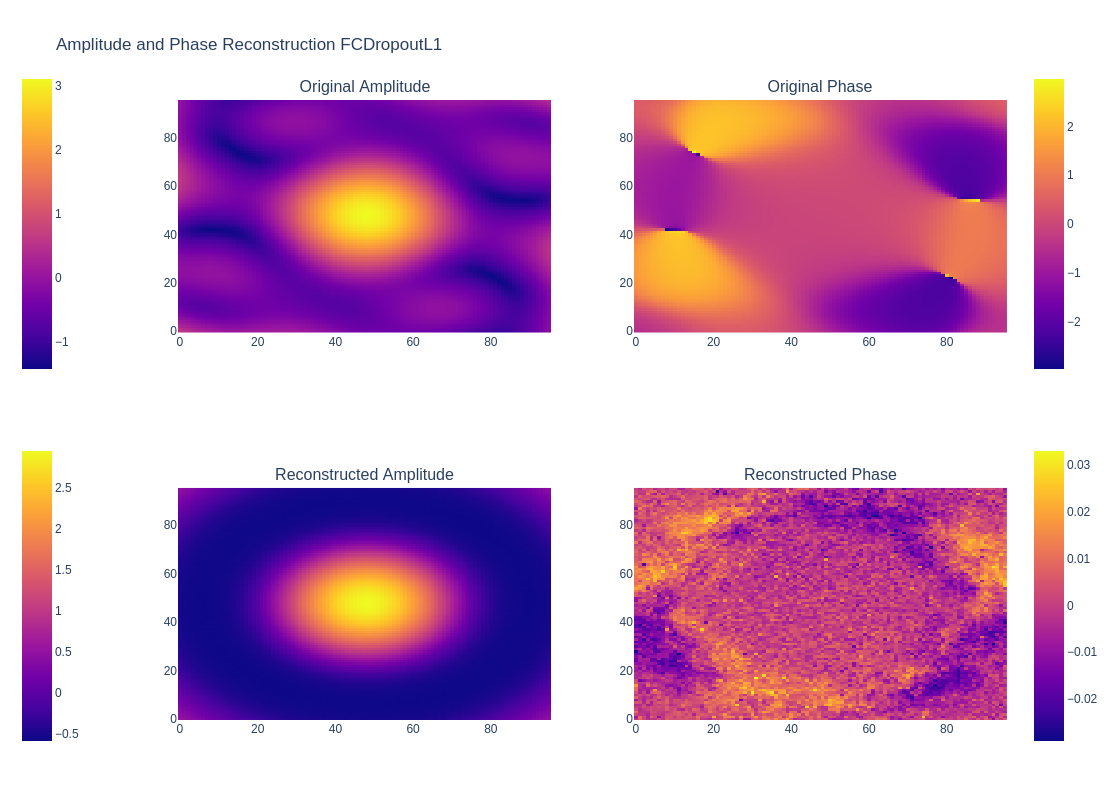

In [8]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    val_fluxes_array[n],
    val_amp_phase_array[n][0],
    val_amp_phase_array[n][1]
    )

1/1 [==============================] - 0s 13ms/step


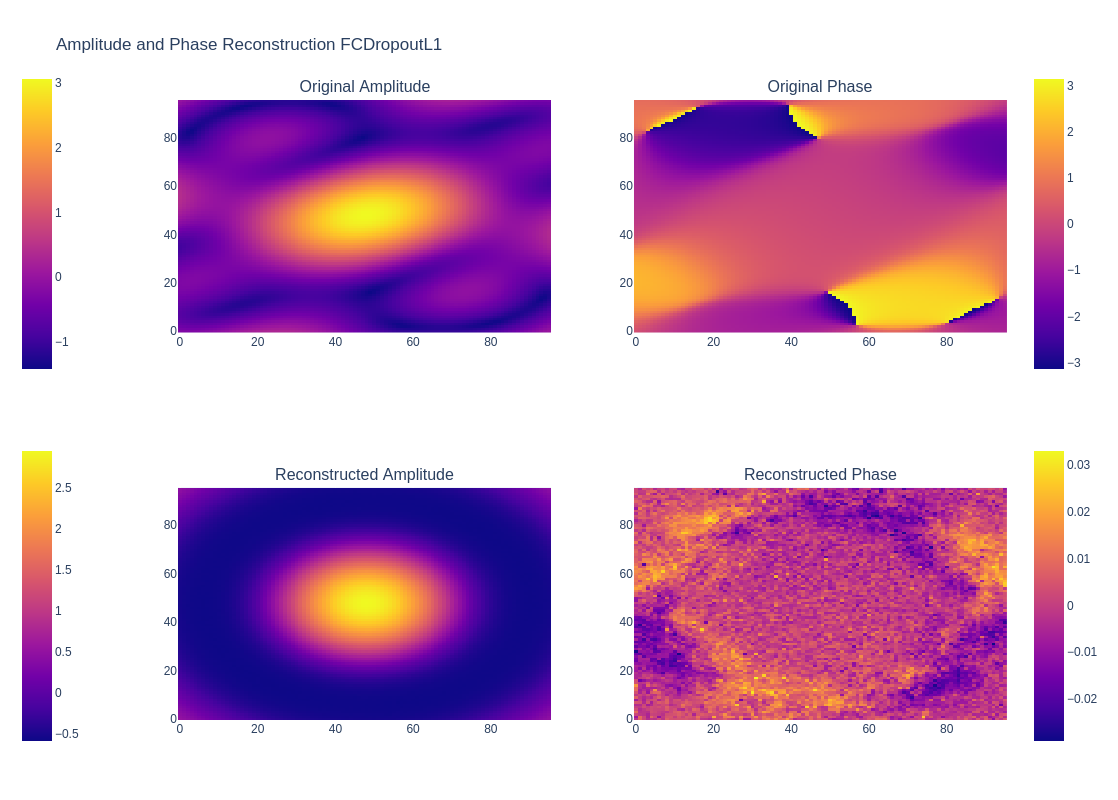

In [9]:
n = 106
plot_fully_connected_amp_phase_prediction(
    model,
    train_fluxes_array[n],
    train_amp_phase_array[n][0],
    train_amp_phase_array[n][1]
    )